# Privacy Preservation in Medication Adherence Data

In [1]:
import torch
import pandas as pd
from pandasql import sqldf
import matplotlib.pyplot as plt
import numpy as np
import random
pysqldf = lambda q: sqldf(q, globals())
from datetime import date
import pydp as dp 
from pydp.algorithms.laplacian import BoundedSum, BoundedMean, Count, Max
import statistics 
import matplotlib.pyplot as plt
epsilon = 0.5
ldp_epsilon = 100
import math

In [2]:
def calculate_age(born):
    today = date.today()
    return today.year - born.year - ((today.month, today.day) < (born.month, born.day))

def getAges(column):
    ages = list()
    for index, row in column.iterrows():
        ages.append(calculate_age(row["Birthdate"]))
    return ages

def parseDateOfBirth(s_data):
    new_age = getAges(s_data[['Birthdate']])
    df = pd.DataFrame({'Age':new_age})
    s_data.insert(1, "Age", df)
    return s_data

def loadData():
    data = pd.read_csv('patients_data.csv')
    print ("============ Attributes ==============")
    for col in data.columns:
        print(col)
    s_data = pd.DataFrame().assign(Birthdate=data['BIRTHDATE'], Race=data['RACE'], Gender = data["GENDER"], City=data["CITY"], Coverage=data["HEALTHCARE_COVERAGE"], Adherence=data["non_adherence"])
    s_data['Birthdate'] = pd.to_datetime(s_data['Birthdate'])
    s_data = parseDateOfBirth(s_data)
    return s_data

def val(arg):
    return round(float(arg),2)

def query_average(col):
    return torch.mean(col.float())
    
def query_sum(col):
    return col.sum()

In [3]:
def printBasicStats (db):    
    female_count = 0
    female_adherent = 0
    male_count = 0
    male_adherent = 0
    total_count = 0
    total_adherent = 0
    for index, row in db.iterrows():
        total_count += 1
        adh = False
        if row["Adherence"]==1:
            adh = True
            total_adherent += 1
        if row["Gender"]=="M":
            male_count += 1
            if adh:
                male_adherent +=1 
        else:
            female_count += 1
            if adh:
                female_adherent += 1
    adherence_rate = (total_adherent/total_count)*100
    adherence_male = (male_adherent/male_count)*100 
    adherence_female = (female_adherent/female_count)*100 
    return {"adherence_rate":adherence_rate,"adherence_male":adherence_male,"adherence_female":adherence_female}

def getByCoverage():
    temp_cov = pysqldf("SELECT round(Avg(Coverage),2) as Coverage, count(*) as Population, Adherence FROM data GROUP BY Adherence;")
    return temp_cov.to_dict()

def getByAge():
    temp_a = pysqldf("SELECT count(*) as Population, floor(avg(Age)) as Age, round(avg(Coverage),2) as average FROM data WHERE Adherence=1")
    temp_b = pysqldf("SELECT count(*) as Population, floor(avg(Age)) as Age, round(avg(Coverage),2) as average FROM data WHERE Adherence=0")
    return temp_a.to_dict(), temp_b.to_dict()

In [4]:
data = loadData()
data.head()

============ Attributes ==============
Id
BIRTHDATE
SSN
FIRST
LAST
RACE
ETHNICITY
GENDER
BIRTHPLACE
CITY
STATE
COUNTY
HEALTHCARE_EXPENSES
HEALTHCARE_COVERAGE
non_adherence


,Birthdate,Age,Race,Gender,City,Coverage,Adherence
0,2003-11-18,19,white,M,Lynn,9863.36,1
1,2009-11-26,13,white,M,Boston,1240.76,0
2,1960-01-20,62,black,M,Middleton,7108.77,1
3,1998-05-31,24,white,M,Pittsfield,3346.40,1
4,2019-05-15,3,white,F,Colrain,774.96,0


In [5]:
print (len(data))

1171


# Raw Insights

## General Insights

In [6]:
counts = printBasicStats (data)
print ("\n======== Adherence Rates ==========")
print ("Adherence Rate = ",str(round(counts["adherence_rate"],4)),"%")
print ("Male Adherence Rate = ",str(round(counts["adherence_male"],4)),"%")
print ("Female Adherence Rate = ",str(round(counts["adherence_female"],4)),"%")


======== Adherence Rates ==========
Adherence Rate =  78.5653 %
Male Adherence Rate =  75.6228 %
Female Adherence Rate =  81.2808 %


In [7]:
stats = getByCoverage()
print ("\n======== (In)adherence By Coverage ==========")
print ("Coverage for Adherent = $",str(stats["Coverage"][1]))
print ("Coverage for Non-Adherent = $",str(stats["Coverage"][0]))


======== (In)adherence By Coverage ==========
Coverage for Adherent = $ 15671.77
Coverage for Non-Adherent = $ 2893.24


In [8]:
ad, inad = getByAge()
print ("\n======== (In)adherence By Age ==========")
print ("Average Age for Adherent = ",str(ad["Age"][0]), "Years Old")
print ("Average Age for Inadherent = ",str(inad["Age"][0]), "Years Old")


======== (In)adherence By Age ==========
Average Age for Adherent =  54.0 Years Old
Average Age for Inadherent =  19.0 Years Old


# Local Differential Privacy

An algorithm π satisfies ϵ-local differential privacy (ϵ-LDP), where ϵ ≥ 0, if and only if for any input v and v′, we have
***
∀y $\epsilon$ Range($\pi$) : Pr[π(v) = y] $\leq$ $e^\epsilon$ Pr[π(v′) = y]
***
where Range(π) denotes the set of all possible outputs of the algorithm π.

In [9]:
data.head()

,Birthdate,Age,Race,Gender,City,Coverage,Adherence
0,2003-11-18,19,white,M,Lynn,9863.36,1
1,2009-11-26,13,white,M,Boston,1240.76,0
2,1960-01-20,62,black,M,Middleton,7108.77,1
3,1998-05-31,24,white,M,Pittsfield,3346.40,1
4,2019-05-15,3,white,F,Colrain,774.96,0


In [10]:
def add_noise(arg, sensitivity, epsilon):
    beta = sensitivity/epsilon
    noise = torch.tensor(np.random.laplace(0, beta, 1))
    return abs(val(arg + noise))

def randomizeResponse(arg, options):
    toss = random.randint(0, 1)
    if toss == 1:
        return arg
    else:
        return options[random.randint(0, 1)]

def simulateLDP(db, eps):
    main_list = list()
    for index, row in db.iterrows():
        age = add_noise(row["Age"], row["Age"], eps)
        coverage = add_noise(row["Coverage"], row["Coverage"], eps)
        gender = randomizeResponse(row["Gender"],["M","F"])
        adherence = randomizeResponse(row["Adherence"], [0,1])                           
        main_list.append((age,row["Race"], gender, row["City"], coverage, adherence))
    return pd.DataFrame(main_list)


def getByColumn(adherence, arg):
    count = 0
    ad_count = 0
    nad_count = 0
    ad_total = 0
    nad_total = 0
    for item in adherence:
        if (item == 1):
            ad_count += 1
            ad_total += arg[count]
        else:
            nad_count += 1
            nad_total += arg[count]
        count += 1
    return (ad_total/ad_count, nad_total/nad_count)

def normalize(arg):
    return round(arg*2-50,4)

In [11]:
p_data = simulateLDP(data, ldp_epsilon)
p_data = p_data.rename(columns={0: 'Age',1:'Race', 2: 'Gender', 3:'City', 4:'Coverage', 5:"Adherence"})

In [12]:
p_data.head()

,Age,Race,Gender,City,Coverage,Adherence
0,18.46,white,F,Lynn,9990.83,1
1,12.96,white,M,Boston,1243.46,1
2,62.88,black,M,Middleton,7017.25,1
3,23.66,white,M,Pittsfield,3415.08,1
4,3.01,white,M,Colrain,786.80,0


In [13]:
adherence_col = torch.tensor(p_data["Adherence"].to_list())
coverage_col = torch.tensor(p_data["Coverage"].to_list())
age_col = torch.tensor(p_data["Age"].to_list())
gender_col = p_data["Gender"].to_list()

In [14]:
ldp_trace = list()
ldp_pstats = list()
ldp_astats = list()
for index in range (1,200):
    temp_data = simulateLDP(data, index)
    temp_data = temp_data.rename(columns={0: 'Age',1:'Race', 2: 'Gender', 3:'City', 4:'Coverage', 5:"Adherence"})
    ldp_trace.append(printBasicStats(temp_data))
    adherence_col = torch.tensor(temp_data["Adherence"].to_list())
    coverage_col = torch.tensor(temp_data["Coverage"].to_list())
    age_col = torch.tensor(temp_data["Age"].to_list())
    gender_col = temp_data["Gender"].to_list()
    ldp_pstats.append(getByColumn(adherence_col, coverage_col))
    ldp_astats.append(getByColumn(adherence_col, age_col))

In [15]:
a_rate = []
a_male = []
a_female = []
a_eps = []
count = 1
for entry in ldp_trace:
    a_rate.append(normalize(entry["adherence_rate"]))
    a_male.append(normalize(entry["adherence_male"]))
    a_female.append(normalize(entry["adherence_female"]))
    a_eps.append(count)
    count += 1

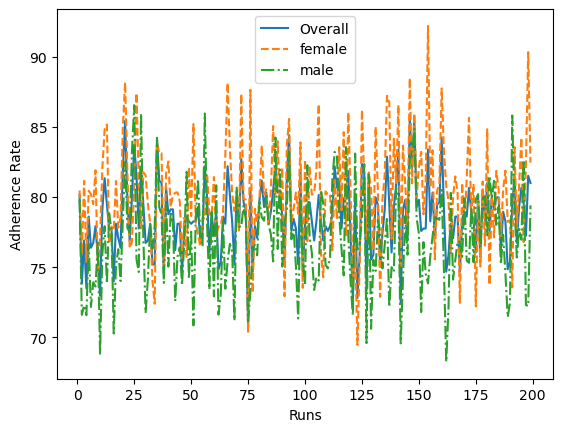

<Figure size 640x480 with 0 Axes>

In [16]:
plt.plot(a_eps, a_rate, label = "Overall", linestyle="-")
plt.plot(a_eps, a_female, label="female", linestyle="--") 
plt.plot(a_eps, a_male, label="male", linestyle="-.") 
plt.legend()
plt.ylabel("Adherence Rate")
plt.xlabel("Runs")
plt.figure(figsize=(8, 6), dpi=80)
plt.show()

In [17]:
pcounts = printBasicStats (p_data)
print ("\n======== Adherence Rates ==========")
print ("Adherence Rate = ",str(round(pcounts["adherence_rate"]*2-50,4)),"%")
print ("Male Adherence Rate = ",str(round(pcounts["adherence_male"]*2-50,4)),"%")
print ("Female Adherence Rate = ",str(round(pcounts["adherence_female"]*2-50,4)),"%")


======== Adherence Rates ==========
Adherence Rate =  83.2195 %
Male Adherence Rate =  82.7496 %
Female Adherence Rate =  83.6667 %


In [18]:
pstats = getByColumn(adherence_col, coverage_col)
print ("\n======== (In)adherence By Coverage ==========")
print ("Coverage for Adherent = $",str(val(pstats[0])))
print ("Coverage for Non-Adherent = $",str(val(pstats[1])))


======== (In)adherence By Coverage ==========
Coverage for Adherent = $ 16110.89
Coverage for Non-Adherent = $ 6900.56


In [19]:
c_ad = []
c_in = []
for item in ldp_pstats:
    c_ad.append(val(item[0]))
    c_in.append(val(item[1]))

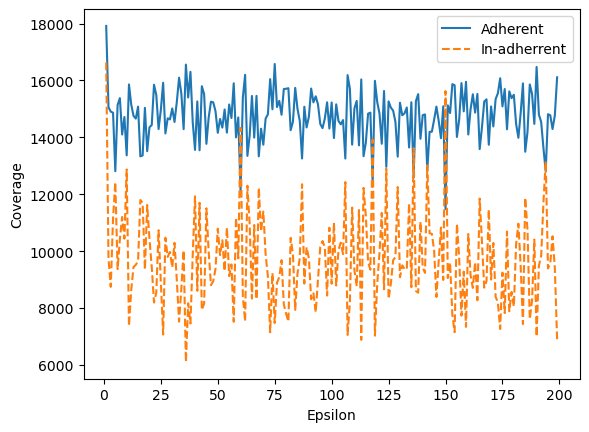

In [42]:
plt.plot(a_eps, c_ad, label = "Adherent", linestyle="-")
plt.plot(a_eps, c_in, label="In-adherrent", linestyle="--")  
plt.legend()
plt.ylabel("Coverage")
plt.xlabel("Epsilon")
plt.show()

In [21]:
getByColumn(adherence_col, coverage_col)

(tensor(16110.8945), tensor(6900.5610))

In [22]:
pstats = getByColumn(adherence_col, age_col)
print ("\n======== (In)adherence By Age ==========")
print ("Average Age for Adherent = ",str(val(pstats[0])), "Years Old")
print ("Average Age for Inadherent = ",str(val(pstats[1])), "Years Old")


======== (In)adherence By Age ==========
Average Age for Adherent =  50.54 Years Old
Average Age for Inadherent =  39.77 Years Old


In [43]:
c_adg = []
c_ing = []
for item in ldp_astats:
    c_adg.append(val(item[0]))
    c_ing.append(val(item[1]))

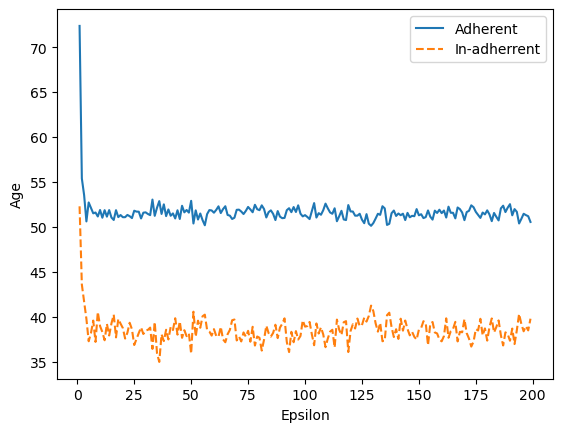

In [44]:
plt.plot(a_eps, c_adg, label = "Adherent", linestyle="-")
plt.plot(a_eps, c_ing, label="In-adherrent", linestyle="--")  
plt.legend()
plt.ylabel("Age")
plt.xlabel("Epsilon")
plt.show()

# Differential Privacy

#### Definition 
A randomized function K gives e-differential privacy if for all data sets D1 and D2 differing on at most one element, and all S ⊆ Range(K), 
***
Pr[K(D1) ∈ S] ≤ exp(ε) × Pr[K(D2) ∈ S]						
***
#### Guarantee
For a participant with personal information x: even if the participant removed her data from the data set, no outputs (and thus consequences of outputs) would become significantly more or less likely.


In [23]:
data.head()

,Birthdate,Age,Race,Gender,City,Coverage,Adherence
0,2003-11-18,19,white,M,Lynn,9863.36,1
1,2009-11-26,13,white,M,Boston,1240.76,0
2,1960-01-20,62,black,M,Middleton,7108.77,1
3,1998-05-31,24,white,M,Pittsfield,3346.40,1
4,2019-05-15,3,white,F,Colrain,774.96,0


In [24]:
def create_neighbor(db, index):
    temp = db.drop(index)
    return temp

def get_parallel_db(db, remove_index):
    return torch.concat((db[0:remove_index], db[(remove_index+1):]))

def get_parallel_dbs(db):
    parallel_dbs = list()
    for i in range (len(db)):
        parallel_dbs.append(get_parallel_db(db,i))
    return parallel_dbs

def find_sensitivity(query, db):
    pdbs = get_parallel_dbs(db)
    full_db_result = query(db)
    max_distance = 0
    for pdb in pdbs:
        pdb_result = query(pdb)
        db_distance = torch.abs(pdb_result - full_db_result)
        if db_distance>max_distance:
            max_distance = db_distance 
    return max_distance

In [25]:
#Queries
def query_adherence_by_gender(adherence, gender, arg):
    a_list = list()
    count = 0
    for g in gender:
        if g == arg:
            a_list.append(adherence[count])
        count += 1
    return torch.tensor(a_list)

def query_by_adherence(adherence, coverage, arg):
    a_list = list()
    count = 0
    for g in adherence:
        if g == arg:
            a_list.append(coverage[count])
        count += 1
    return torch.tensor(a_list)
    
def adherence_rate(col):
    return (col.sum()/col.shape[0])*100

def laplacian_mechanism(db, query, sensitivity, epsilon):
    beta = sensitivity/epsilon
    noise = torch.tensor(np.random.laplace(0, beta, 1))
    return query(db) + noise

In [26]:
adherence_col = torch.tensor(data["Adherence"].to_list())
coverage_col = torch.tensor(data["Coverage"].to_list())
age_col = torch.tensor(data["Age"].to_list())
gender_col = data["Gender"].to_list()

In [27]:
adherence_sens = find_sensitivity(adherence_rate, adherence_col)
adherence = laplacian_mechanism(adherence_col, adherence_rate, adherence_sens, epsilon)
adherence

tensor([78.5880], dtype=torch.float64)

In [28]:
adherence_male_col = query_adherence_by_gender(adherence_col, gender_col, "M")
adherence_female_col = query_adherence_by_gender(adherence_col, gender_col, "F")

In [29]:
adherence_sens = find_sensitivity(adherence_rate, adherence_male_col)
adherence_male = laplacian_mechanism(adherence_male_col, adherence_rate, adherence_sens, epsilon)
adherence_male

tensor([75.6223], dtype=torch.float64)

In [30]:
adherence_sens = find_sensitivity(adherence_rate, adherence_female_col)
adherence_female = laplacian_mechanism(adherence_female_col, adherence_rate, adherence_sens, epsilon)
adherence_female

tensor([81.0302], dtype=torch.float64)

#### Observation 1.0

In [31]:
print ("\n======== Adherence Rates ==========")
print ("Adherence Rate = ",val(adherence),"%")
print ("Male Adherence Rate = ",val(adherence_male),"%")
print ("Female Adherence Rate = ",val(adherence_female),"%")


======== Adherence Rates ==========
Adherence Rate =  78.59 %
Male Adherence Rate =  75.62 %
Female Adherence Rate =  81.03 %


In [32]:
coverage_adherent = query_by_adherence(adherence_col, coverage_col, 1)
coverage_nadherent = query_by_adherence(adherence_col, coverage_col, 0)

In [33]:
adherence_sens = find_sensitivity(query_average, coverage_adherent)
adherenct_cov = laplacian_mechanism(coverage_adherent, query_average, adherence_sens, epsilon)
adherenct_cov

tensor([12040.9182], dtype=torch.float64)

In [34]:
adherence_sens = find_sensitivity(query_average, coverage_nadherent)
adherenct_ncov = laplacian_mechanism(coverage_nadherent, query_average, adherence_sens, epsilon)
adherenct_ncov

tensor([2912.6037], dtype=torch.float64)

#### Observation 2.0

In [35]:
print ("\n======== (In)adherence By Coverage ==========")
print ("Coverage for Adherent = $",val(adherenct_cov))
print ("Coverage for Non-Adherent = $",val(adherenct_ncov))


======== (In)adherence By Coverage ==========
Coverage for Adherent = $ 12040.92
Coverage for Non-Adherent = $ 2912.6


In [36]:
age_adherence = query_by_adherence(adherence_col, age_col, 1)
age_nadherence = query_by_adherence(adherence_col, age_col, 0)

In [37]:
adherence_sens = find_sensitivity(query_average, age_adherence)
adherent_age = laplacian_mechanism(age_adherence, query_average, adherence_sens, epsilon)
adherent_age

tensor([54.2216], dtype=torch.float64)

In [38]:
adherence_sens = find_sensitivity(query_average, age_nadherence)
nadherent_age = laplacian_mechanism(age_nadherence, query_average, adherence_sens, epsilon)
nadherent_age

tensor([19.9970], dtype=torch.float64)

#### Observation 3.0

In [39]:
print ("\n======== (In)adherence By Age ==========")
print ("Average Age for Adherent = ",val(adherent_age), "Years Old")
print ("Average Age for Inadherent = ",val(nadherent_age), "Years Old")


======== (In)adherence By Age ==========
Average Age for Adherent =  54.22 Years Old
Average Age for Inadherent =  20.0 Years Old


In [40]:
def sampleEpsilon():
    adherence_sens = find_sensitivity(adherence_rate, adherence_col)
    ep = []
    age_l = []
    for index in range (1000, 100000):
        epsilon = index/10000
        ad = laplacian_mechanism(adherence_col, adherence_rate, adherence_sens, epsilon)
        ep.append(epsilon)
        age_l.append(ad)
    area = 1  # 0 to 15 point radii
    plt.scatter(ep, age_l, s=area)
    plt.ylabel("Average Age")
    plt.xlabel("Epsilon")
    plt.figure(figsize=(8, 6), dpi=80)
    plt.show()

/Users/lengwe/opt/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:2830: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  order=order, subok=True, ndmin=ndmin)
/Users/lengwe/opt/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:2830: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  order=order, subok=True, ndmin=ndmin)


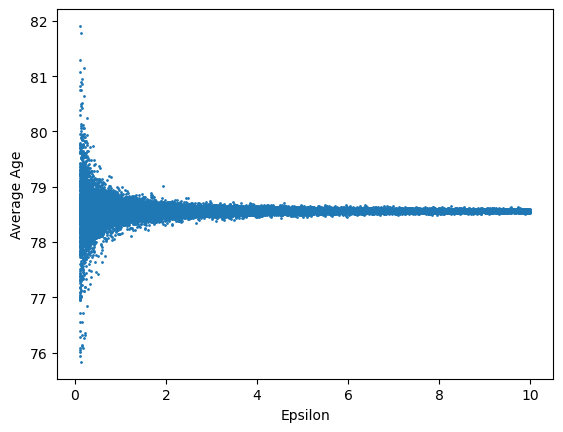

<Figure size 640x480 with 0 Axes>

In [41]:
sampleEpsilon()